In [1]:
"""

"""

'\n\n'

In [2]:
is_skip = True
# Data params
batch_size = 1500; # batch_size = 16
encode_len = 100
pred_len = 30

valid_start_date = "2020-01-01"
hint_days = 30

# Model params
d_model = 128
nhead = 4
d_ff = 256
dropout = 0.1
num_layers = 4

# Import

In [3]:
import copy
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm

import torch
from pytorch_model_summary import summary

device = torch.device("cuda:0")

# Data

In [4]:
if not is_skip:
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_raw = pd.merge(df_trans, df_meta, on="article_id")

In [5]:
def preprocess(data, min_size=2):
    data = data.copy()

    # Make sales
    data = data.groupby(["t_dat", "article_id"], as_index=False).agg(sales=("customer_id", "count"))

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["article_id"] = data["article_id"].fillna(method="ffill")

    # Accumulate sales
    data = data.sort_values(["article_id", "t_dat"]).reset_index(drop=True)
    data["sales"] = data.groupby("article_id")["sales"].cumsum()
    
    # Data to list
    data = data.groupby("article_id", as_index=False)["sales"].agg(list)

    # Size restriction
    data["size"] = data["sales"].str.len()
    data = data[data["size"] >= min_size]
    return data

if not is_skip:
    df_prep = df_raw[df_raw["index_name"]=="Ladieswear"].reset_index(drop=True)
    
    df_train = df_prep[df_prep["t_dat"] < valid_start_date]
    df_train = preprocess(df_train, min_size=encode_len+pred_len)
    df_train.to_parquet("df_train.pq")

    df_valid = df_prep[df_prep["t_dat"] >= valid_start_date]
    df_valid = preprocess(df_valid, min_size=encode_len+pred_len)
    df_valid.to_parquet("df_valid.pq")    

In [6]:
df_train = pd.read_parquet("df_train.pq")
df_valid = pd.read_parquet("df_valid.pq")

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, encode_len, pred_len):
        self.encode_len, self.pred_len = encode_len, pred_len
        self.sales_li, self.scaler_li = [], []
        
        for _, row in tqdm(data.iterrows()):
            scaler = StandardScaler()
            sales = row["sales"]
            sales = scaler.fit_transform(sales.reshape(-1,1)).reshape(-1)
            # sales = np.log1p(sales)
            sales = torch.FloatTensor(sales).unfold(0, encode_len+pred_len, 1)
            
            scaler = np.repeat(np.array([scaler]), sales.shape[0], 0)
            
            self.sales_li.append(sales)
            self.scaler_li.append(scaler)
        
        self.sales_li = torch.concat(self.sales_li)
        self.scaler_li = np.concatenate(self.scaler_li)
       
    def __len__(self):
        return self.sales_li.shape[0]
    
    def __getitem__(self, idx):
        sales = self.sales_li[idx]
        scaler = self.scaler_li[idx]
        decoder_input = sales[:encode_len+1].reshape(-1, 1)
        y = sales[-pred_len-1:].reshape(-1, 1)

        return {"decoder_input":decoder_input,
                "scaler": scaler,
                "y": y}

def collate_fn(batch_li):
    decoder_input = torch.FloatTensor(np.array([batch["decoder_input"].numpy() for batch in batch_li]))
    scaler = [batch["scaler"] for batch in batch_li]
    y = torch.FloatTensor(np.array([batch["y"].numpy() for batch in batch_li]))

    return {"decoder_input":decoder_input,
        "scaler": scaler,
        "y": y}

train_dataset = Dataset(df_train, encode_len, pred_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

valid_dataset = Dataset(df_valid, encode_len, pred_len)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

for data in train_dataloader:
    print("decoder_input:", data["decoder_input"].shape)
    print("y:", data["y"].shape)
    break

13822it [00:02, 5178.70it/s]
10157it [00:01, 5401.54it/s]


decoder_input: torch.Size([1500, 101, 1])
y: torch.Size([1500, 31, 1])


# Architecture

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, nhead, num_layers, pred_len):
        super().__init__()
        self.pred_len = pred_len
        self.lstm = torch.nn.LSTM(1, d_model)
        self.self_attn = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, batch_first=True), num_layers)
        self.linear1 = torch.nn.Linear(d_model, 1)
        self.linear2 = torch.nn.Linear(d_model, 1)
        self.linear3 = torch.nn.Linear(d_model, 1)

    def get_paddingmask(self, data):
        return torch.where(data==-1, -torch.inf, 0).to(device)

    def forward(self, x):
        # Architecture
        lstm, _ = self.lstm(x)
        self_attn = self.self_attn(lstm)
        self_attn = self_attn[:, -self.pred_len-1:, :]
        upper = self.linear1(self_attn)
        lower = self.linear2(self_attn)
        pred = self.linear3(self_attn)
        return upper, lower, pred

model = Transformer(d_model, nhead, num_layers, pred_len)
model.to(device)
summary(model,
        data["decoder_input"].to(device),
        show_parent_layers=True, print_summary=True)

---------------------------------------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)                                       Output Shape         Param #     Tr. Param #
     Transformer                  LSTM-1     [1500, 101, 128], [1, 101, 128], [1, 101, 128]          67,072          67,072
     Transformer    TransformerEncoder-2                                   [1500, 101, 128]       2,372,096       2,372,096
     Transformer                Linear-3                                      [1500, 31, 1]             129             129
     Transformer                Linear-4                                      [1500, 31, 1]             129             129
     Transformer                Linear-5                                      [1500, 31, 1]             129             129
Total params: 2,439,555
Trainable params: 2,439,555
Non-trainable params: 0
--------------------------------------------------------

'---------------------------------------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)                                       Output Shape         Param #     Tr. Param #\n===========================================================================================================================\n     Transformer                  LSTM-1     [1500, 101, 128], [1, 101, 128], [1, 101, 128]          67,072          67,072\n     Transformer    TransformerEncoder-2                                   [1500, 101, 128]       2,372,096       2,372,096\n     Transformer                Linear-3                                      [1500, 31, 1]             129             129\n     Transformer                Linear-4                                      [1500, 31, 1]             129             129\n     Transformer                Linear-5                                      [1500, 31, 1]             129             129\

# Train

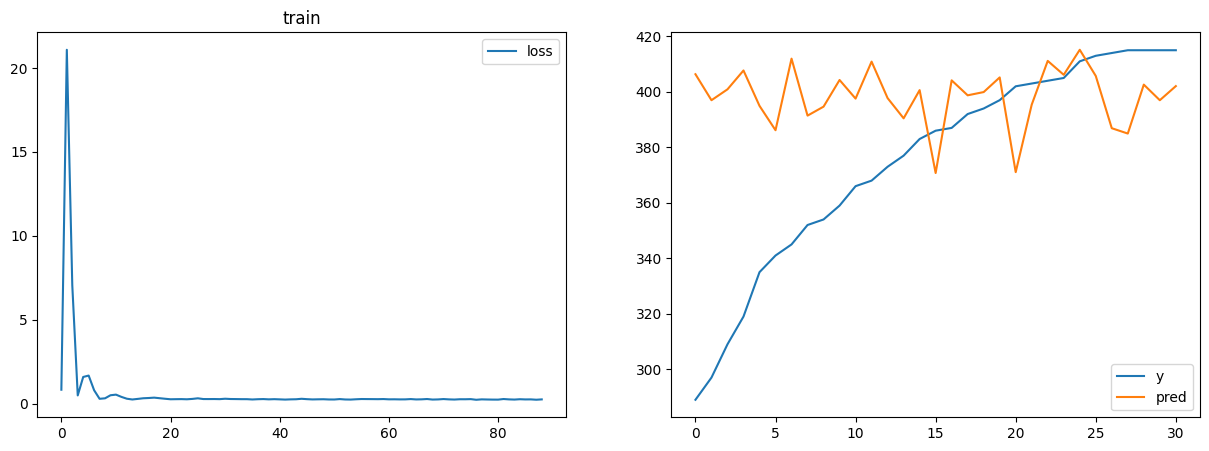

epoch 0 - loss: 0.62382:   6%|▌         | 89/1502 [00:34<09:00,  2.61it/s]


KeyboardInterrupt: 

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss(reduction="none")

def loss_fn(upperbound, lowerbound, pred, y):
    outside_interval = torch.max(y - upperbound, torch.zeros(y.shape).to(device)) + torch.max(lowerbound - y, torch.zeros(y.shape).to(device))
    interval_width = upperbound - lowerbound
    # interval_penalty = 0.1*interval_width

    pred_loss = mse_loss(pred, y)
    loss = torch.mean(pred_loss)
    
    return loss

class Report():
    def __init__(self, window, name):
        self.window, self.name = window, name
        self.loss_li = []

    def plot_sample(self, loss_li, y, pred):
        plt.figure(figsize=(15,5))
        nrows, ncols = 1,2

        plt.subplot(nrows, ncols, 1)
        plt.plot(loss_li, label="loss")
        plt.title(self.name)
        plt.legend()

        plt.subplot(nrows, ncols, 2)
        plt.plot(y, label="y")
        plt.plot(pred, label="pred")
        plt.legend()

        plt.show()

    def report(self, loss, y, pred, pbar, e, isplot=False):
        self.loss_li.append(loss.item())
        pbar.set_description(f"epoch {e} - loss: {np.round(np.mean(self.loss_li[-self.window:]), 5)}")
        
        if isplot:
            clear_output(wait=True)
            self.plot_sample(self.loss_li[-self.window:], y[-1], pred[-1])

def train(e):
    model.train()
    pbar = tqdm(train_dataloader)
    report = Report(window=100, name="train")

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        upper, lower, pred = model(data["decoder_input"].to(device))
        loss = loss_fn(upper, lower, pred, data["y"].to(device))
        loss.backward()
        optimizer.step()

        scaler = data["scaler"][-1]
        upper = scaler.inverse_transform(upper.squeeze(-1).detach().cpu().numpy())
        lower = scaler.inverse_transform(lower.squeeze(-1).detach().cpu().numpy())
        pred = scaler.inverse_transform(pred.squeeze(-1).detach().cpu().numpy())
        # upper = np.expm1(upper.squeeze(-1).detach().cpu().numpy())
        # lower = np.expm1(lower.squeeze(-1).detach().cpu().numpy())
        # pred = np.expm1(pred.squeeze(-1).detach().cpu().numpy())
        # pred = np.stack([upper, lower, pred], axis=-1)

        y = scaler.inverse_transform(data["y"].squeeze(-1).detach().cpu().numpy())
        # y = np.expm1(data["y"].squeeze(-1).detach().cpu().numpy())
        report.report(loss, y, pred, pbar, e, isplot=True)

epoch = 10
for e in range(epoch):
    train(e)
    # valid(e)

# Eval

In [ ]:
model.eval()
pbar = tqdm(valid_dataloader)
report = Report(window=100, name="valid")

for n, data in enumerate(pbar):
    with torch.no_grad():
        upper, lower, pred = model(data["decoder_input"].to(device))
        loss = loss_fn(upper, lower, pred, data["y"].to(device))
        
        scaler = data["scaler"][-1]
        upper = scaler.inverse_transform(upper.squeeze(-1).detach().cpu().numpy())
        lower = scaler.inverse_transform(lower.squeeze(-1).detach().cpu().numpy())
        pred = scaler.inverse_transform(pred.squeeze(-1).detach().cpu().numpy())
        # pred = np.stack([upper, lower, pred], axis=-1)
        # upper = np.expm1(upper.squeeze(-1).detach().cpu().numpy())
        # lower = np.expm1(lower.squeeze(-1).detach().cpu().numpy())
        # pred = np.expm1(pred.squeeze(-1).detach().cpu().numpy())
        # pred = np.stack([upper, lower, pred], axis=-1)

        y = scaler.inverse_transform(data["y"].squeeze(-1).detach().cpu().numpy())
        # y = np.expm1(data["y"].squeeze(-1).detach().cpu().numpy())
        report.report(loss, y, pred, pbar, e, isplot=True)
        input()
        

NameError: name 'model' is not defined